<a href="https://colab.research.google.com/github/Mohammad-debug/Pneumonia-Caps/blob/main/Copy_of_BostonHouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geppy

In [ ]:
import geppy as gep
from deap import creator, base, tools
import numpy as np
import random

import operator 
import math
import datetime

# for reproduction
s = 0
random.seed(s)
np.random.seed(s)

In [ ]:


import os

#doublecheck the data is there
print(os.listdir("/content"))
import pandas as pd

# read in the data to pandas
PowerPlantData1 = pd.read_csv("/content/BOSTON.csv")



['.config', 'numerical_expression_tree', 'BOSTON.csv', 'numerical_expression_tree.png', 'sample_data']


### we must normalize our data for neural networks to perform optimally

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
# Scale both the training inputs and outputs
PowerPlantData = scaler.fit_transform(PowerPlantData1)
#scaled_test = scaler.transform(test_df)

In [ ]:
PowerPlantData = pd.DataFrame(PowerPlantData1, columns=PowerPlantData1.columns.values)

In [ ]:
PowerPlantData.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [ ]:
msk = np.random.rand(len(PowerPlantData)) < 0.8
train = PowerPlantData[msk]
holdout = PowerPlantData[~msk]

In [ ]:
# check the number of records we'll validate our MSE with
holdout.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,4.907116,9.702020,12.657071,0.090909,0.586927,6.236768,73.816162,3.383600,11.111111,445.272727,18.378788,366.255051,13.944242,21.119192
std,10.801668,21.303195,6.817905,0.288943,0.133590,0.765203,28.880410,1.973555,9.452231,178.037764,2.268069,70.939940,7.217176,9.100938
min,0.019650,0.000000,1.250000,0.000000,0.385000,4.368000,6.600000,1.332500,1.000000,188.000000,13.000000,6.680000,2.980000,7.200000
25%,0.122415,0.000000,6.305000,0.000000,0.488500,5.845500,53.750000,1.951150,4.000000,302.000000,16.600000,375.100000,7.255000,14.700000
50%,0.663510,0.000000,13.890000,0.000000,0.573000,6.176000,88.800000,2.545100,5.000000,403.000000,19.200000,390.950000,13.440000,20.000000
75%,5.977220,0.000000,18.100000,0.000000,0.696500,6.570500,96.050000,4.316900,24.000000,666.000000,20.200000,396.480000,18.095000,24.750000
max,88.976200,80.000000,27.740000,1.000000,0.871000,8.780000,100.000000,9.220300,24.000000,711.000000,21.200000,396.900000,30.810000,50.000000


In [ ]:
# check the number of records we'll train our algorithm with
train.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000
mean,3.298866,11.767813,10.766978,0.063882,0.546855,6.296278,67.300000,3.895123,9.169533,399.228501,18.474201,354.343514,12.338993,22.876658
std,7.959722,23.794756,6.827872,0.244844,0.109905,0.687036,27.855194,2.126909,8.485180,165.118496,2.141589,95.522532,7.095855,9.198587
min,0.006320,0.000000,0.460000,0.000000,0.389000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.071580,0.000000,5.040000,0.000000,0.448000,5.888500,43.000000,2.122300,4.000000,277.000000,17.400000,375.600000,6.970000,17.550000
50%,0.228760,0.000000,8.560000,0.000000,0.524000,6.211000,74.500000,3.375100,5.000000,329.000000,19.000000,391.830000,10.560000,21.500000
75%,2.354780,17.750000,18.100000,0.000000,0.624000,6.622000,93.300000,5.400700,8.000000,453.000000,20.200000,396.220000,16.295000,25.200000
max,73.534100,100.000000,27.740000,1.000000,0.871000,8.704000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [ ]:


# copy and convert our pandas dataframe into numpy variables.
# I will leave the target at Y, as I can't see where to set that in the code, but it's in there somehow!

# NOTE: I'm only feeding in the TRAIN values to the algorithms. Later I will independely check
# the MSE myself using a holdout test dataset

#X1 = train['X1 transaction date'].values
crim = train['crim'].values
zn = train['zn'].values
indus = train['indus'].values
chas = train['chas'].values
nox = train['nox'].values
rm = train['rm'].values#
age = train['age'].values
dis = train['dis'].values
rad = train['rad'].values
tax = train['tax'].values
ptratio = train['ptratio'].values
black = train['black'].values
lstat = train['lstat'].values#
Y = train['medv'].values



In [ ]:


def protected_div(x1, x2):
    if abs(x2) < 1e-6:
        return 1
    return x1 / x2



In [ ]:
pset = gep.PrimitiveSet('Main', input_names=['crim','zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','black','lstat'])

In [ ]:
pset.add_function(operator.add, 2)
pset.add_function(operator.sub, 2)
pset.add_function(operator.mul, 2)
pset.add_function(protected_div, 2)
pset.add_function(math.sin, 1)        # I tested adding my own functions
pset.add_function(math.cos, 1)
pset.add_function(math.tan, 1)
pset.add_rnc_terminal()

In [ ]:
from deap import creator, base, tools

creator.create("FitnessMin", base.Fitness, weights=(-1,))  # to minimize the objective (fitness)
creator.create("Individual", gep.Chromosome, fitness=creator.FitnessMin)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
h = 20        # head length
n_genes = 2    # number of genes in a chromosome
r = 13         # length of the RNC array
enable_ls = True # whether to apply the linear scaling technique

In [ ]:
toolbox = gep.Toolbox()
toolbox.register('rnc_gen', random.randint, a=-10, b=10)   # each RNC is random integer within [-5, 5]
toolbox.register('gene_gen', gep.GeneDc, pset=pset, head_length=h, rnc_gen=toolbox.rnc_gen, rnc_array_length=r)
toolbox.register('individual', creator.Individual, gene_gen=toolbox.gene_gen, n_genes=n_genes, linker=operator.add)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# compile utility: which translates an individual into an executable function (Lambda)
toolbox.register('compile', gep.compile_, pset=pset)

In [ ]:
# as a test I'm going to try and accelerate the fitness function
from numba import jit

@jit
def evaluate(individual):
    """Evalute the fitness of an individual: MAE (mean absolute error)"""
    func = toolbox.compile(individual)
    
    # below call the individual as a function over the inputs
    
    # Yp = np.array(list(map(func, X)))
    Yp = np.array(list(map(func, rm,age,dis,rad,tax,ptratio,black,lstat))) 
    
    # return the MSE as we are evaluating on it anyway - then the stats are more fun to watch...
    return np.mean((Y - Yp) ** 2),

In [ ]:
from numba import jit

@jit
def evaluate_ls(individual):
    """
    First apply linear scaling (ls) to the individual 
    and then evaluate its fitness: MSE (mean squared error)
    """
    func = toolbox.compile(individual)
    Yp = np.array(list(map(func, crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat)))
    
    # special cases which cannot be handled by np.linalg.lstsq: (1) individual has only a terminal 
    #  (2) individual returns the same value for all test cases, like 'x - x + 10'. np.linalg.lstsq will fail in such cases.
    # That is, the predicated value for all the examples remains identical, which may happen in the evolution.
    if isinstance(Yp, np.ndarray):
        Q = np.hstack((np.reshape(Yp, (-1, 1)), np.ones((len(Yp), 1))))
        (individual.a, individual.b), residuals, _, _ = np.linalg.lstsq(Q, Y)   
        # residuals is the sum of squared errors
        if residuals.size > 0:
            return residuals[0] / len(Y),   # MSE
    
    # regarding the above special cases, the optimal linear scaling w.r.t LSM is just the mean of true target values
    individual.a = 0
    individual.b = np.mean(Y)
    return np.mean((Y - individual.b) ** 2),

In [ ]:
if enable_ls:
    toolbox.register('evaluate', evaluate_ls)
else:
    toolbox.register('evaluate', evaluate)

In [ ]:


toolbox.register('select', tools.selTournament, tournsize=3)
# 1. general operators
toolbox.register('mut_uniform', gep.mutate_uniform, pset=pset, ind_pb=0.05, pb=1)
toolbox.register('mut_invert', gep.invert, pb=0.1)
toolbox.register('mut_is_transpose', gep.is_transpose, pb=0.1)
toolbox.register('mut_ris_transpose', gep.ris_transpose, pb=0.1)
toolbox.register('mut_gene_transpose', gep.gene_transpose, pb=0.1)
toolbox.register('cx_1p', gep.crossover_one_point, pb=0.3)
toolbox.register('cx_2p', gep.crossover_two_point, pb=0.2)
toolbox.register('cx_gene', gep.crossover_gene, pb=0.1)
# 2. Dc-specific operators
toolbox.register('mut_dc', gep.mutate_uniform_dc, ind_pb=0.05, pb=1)
toolbox.register('mut_invert_dc', gep.invert_dc, pb=0.1)
toolbox.register('mut_transpose_dc', gep.transpose_dc, pb=0.1)
# for some uniform mutations, we can also assign the ind_pb a string to indicate our expected number of point mutations in an individual
toolbox.register('mut_rnc_array_dc', gep.mutate_rnc_array_dc, rnc_gen=toolbox.rnc_gen, ind_pb='0.5p')
toolbox.pbs['mut_rnc_array_dc'] = 1  # we can also give the probability via the pbs property



In [ ]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [ ]:


# size of population and number of generations
n_pop = 180
n_gen = 100

#100 3000

champs = 3

pop = toolbox.population(n=n_pop) # 
hof = tools.HallOfFame(champs) 

In [ ]:
startDT = datetime.datetime.now()
print (str(startDT))


2021-03-05 16:59:04.782402


In [ ]:


# start evolution
pop, log = gep.gep_simple(pop, toolbox, n_generations=n_gen, n_elites=1,
                          stats=stats, hall_of_fame=hof, verbose=True)



/usr/local/lib/python3.7/dist-packages/geppy/algorithms/basic.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  for ind, fit in zip(invalid_individuals, fitnesses):


gen	nevals	avg    	std    	min    	max    
0  	180   	71.9186	11.0161	33.0917	84.4059
1  	179   	65.651 	12.6852	33.0917	84.4053
2  	179   	59.6912	14.4797	33.0917	84.3729
3  	179   	51.1471	15.2236	33.0917	84.4053
4  	179   	47.0499	15.3444	33.0917	84.4059
5  	179   	44.7254	14.7718	29.5627	84.3816
6  	179   	45.2911	16.1762	29.5627	84.3922
7  	179   	45.8597	17.3398	29.5627	84.3835
8  	179   	43.9615	16.0825	29.5627	84.3972
9  	179   	40.9763	13.8739	24.9279	84.2848
10 	179   	43.4725	18.5404	24.9279	84.2763
11 	179   	44.143 	18.7377	24.9279	84.3786
12 	179   	42.5469	17.7175	24.9279	84.4055
13 	179   	39.9658	16.6498	24.9279	84.4061
14 	179   	41.0496	17.7595	24.9272	84.3944
15 	179   	41.8311	18.1748	24.9272	84.4048
16 	179   	42.3135	19.1413	24.8569	84.3982
17 	179   	44.3965	20.3778	24.8569	84.4059
18 	179   	42.4914	19.1811	24.8146	84.4061
19 	179   	39.2659	18.1248	24.8146	84.4023
20 	179   	43.9872	20.8493	24.8146	84.4059
21 	179   	42.8477	19.8418	23.2524	84.4052
22 	179   	

In [ ]:
print ("Evolution times were:\n\nStarted:\t", startDT, "\nEnded:   \t", str(datetime.datetime.now()))

Evolution times were:

Started:	 2021-03-05 16:59:04.782402 
Ended:   	 2021-03-05 17:02:31.085416


In [ ]:


print(hof[0])



add(
	add(lstat, sub(cos(tan(zn)), add(rm, rm))),
	add(mul(cos(rm), add(dis, 8)), sub(ptratio, rm))
)


In [ ]:


# print the best symbolic regression we found:
best_ind = hof[0]
symplified_best = gep.simplify(best_ind)

if enable_ls:
    symplified_best = best_ind.a * symplified_best + best_ind.b

key= '''
#Given training examples of

    AT = Atmospheric Temperature (C)
    V = Exhaust Vacuum Speed
    AP = Atmospheric Pressure
    RH = Relative Humidity

we trained a computer using Genetic Algorithms to predict the 

    PE = Power Output

Our symbolic regression process found the following equation offers our best prediction:

'''

print('\n', key,'\t', str(symplified_best), '\n\nwhich formally is presented as:\n\n')

from sympy import *
init_printing()
symplified_best


 
#Given training examples of

    AT = Atmospheric Temperature (C)
    V = Exhaust Vacuum Speed
    AP = Atmospheric Pressure
    RH = Relative Humidity

we trained a computer using Genetic Algorithms to predict the 

    PE = Power Output

Our symbolic regression process found the following equation offers our best prediction:

 	 -0.776168824557747*lstat - 0.776168824557747*ptratio + 2.32850647367324*rm - 0.776168824557747*(dis + 8)*cos(rm) - 0.776168824557747*cos(tan(zn)) + 40.2676568980662 

which formally is presented as:




In [ ]:

# we want to use symbol labels instead of words in the tree graph
rename_labels = {'add': '+', 'sub': '-', 'mul': '*', 'protected_div': '/'}  
gep.export_expression_tree(best_ind, rename_labels, 'numerical_expression_tree.png')



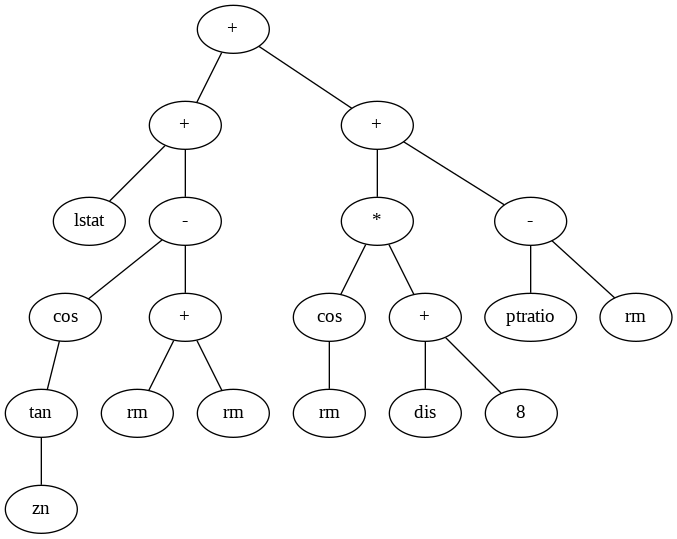

In [ ]:
# show the above image here for convenience
from IPython.display import Image
Image(filename='numerical_expression_tree.png')

In [ ]:
crim = train['crim'].values
zn = train['zn'].values
indus = train['indus'].values
chas = train['chas'].values
nox = train['nox'].values
rm = train['rm'].values#
age = train['age'].values
dis = train['dis'].values
rad = train['rad'].values
tax = train['tax'].values
ptratio = train['ptratio'].values
black = train['black'].values
lstat = train['lstat'].values#
Y = train['medv'].values
n=indus.size
print(n)
arr=np.zeros(n)
print(arr.size)
for i in range(0,n):
    arr[i]=  -0.776168824557747*lstat[i] - 0.776168824557747*ptratio[i] + 2.32850647367324*rm[i] - 0.776168824557747*(dis[i] + 8)*cos(rm[i]) - 0.776168824557747*cos(tan(zn[i])) + 40.2676568980662

407
407


In [ ]:

#Train
from sklearn.metrics import mean_squared_error, r2_score
print("Mean squared error: %.7f" % mean_squared_error(Y, arr))
print("R2 score : %.7f" % r2_score(Y, arr))
a=np.sqrt(mean_squared_error(Y, arr))
print("RMSE  : %.7f" % a)

Mean squared error: 17.7298433
R2 score : 0.7899460
RMSE  : 4.2106821


In [ ]:
#test

crim = holdout['crim'].values
zn = holdout['zn'].values
indus = holdout['indus'].values
chas = holdout['chas'].values
nox = holdout['nox'].values
rm = holdout['rm'].values
age = holdout['age'].values
dis = holdout['dis'].values
rad = holdout['rad'].values
tax = holdout['tax'].values
ptratio = holdout['ptratio'].values
black = holdout['black'].values
lstat = holdout['lstat'].values
Y2 = holdout['medv'].values

n=indus.size
print(n)
arr2=np.zeros(n)
print(arr2.size)
for i in range(0,n):
     arr2[i]=   -0.776168824557747*lstat[i] - 0.776168824557747*ptratio[i] + 2.32850647367324*rm[i] - 0.776168824557747*(dis[i] + 8)*cos(rm[i]) - 0.776168824557747*cos(tan(zn[i])) + 40.2676568980662

print("Mean squared error: %.7f" % mean_squared_error(Y2, arr2))
print("R2 score : %.7f" % r2_score(Y2, arr2))
a=np.sqrt(mean_squared_error(Y2, arr2))
print("RMSE  : %.7f" % a)
#-0.507097948563564*sin(sin(2*lstat[i])) - 0.507097948563564*cos(rm[i]*tan(cos(ptratio[i]))) + 1.0507016967642
#-0.220643443514503*sin(lstat[i] - sin(rm[i] - tan(ptratio[i])) + tan(dis[i] + lstat[i])) - 0.220643443514503*tan(sin(2*lstat[i] - tan(rm[i]))) + 0.549942691732136

99
99
Mean squared error: 25.1178144
R2 score : 0.6936495
RMSE  : 5.0117676


Extras




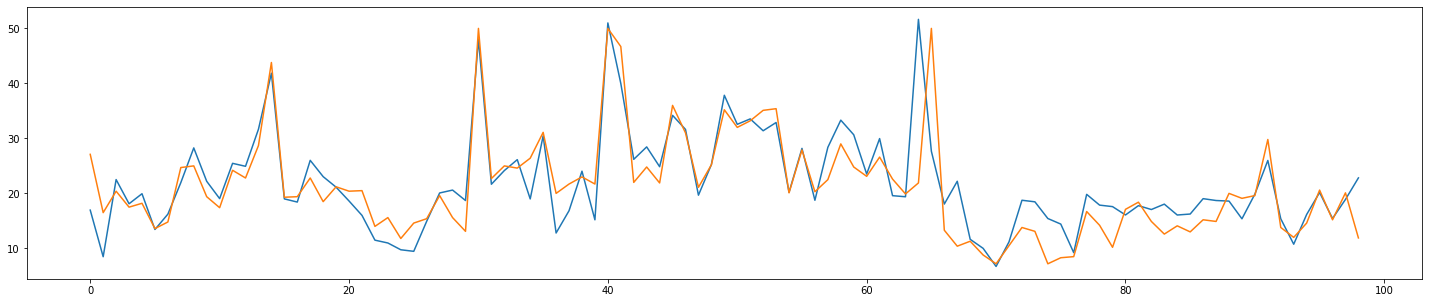

In [ ]:
#Test
from matplotlib import pyplot
pyplot.rcParams['figure.figsize'] = [25, 5]
plotlen=200
pyplot.plot(arr2)# predictions are in blue
pyplot.plot(Y2) # actual values are in orange
pyplot.show()

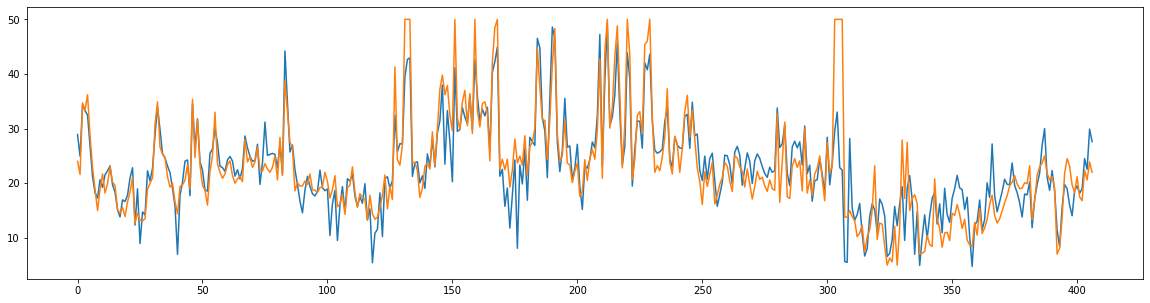

In [ ]:
#Train
from matplotlib import pyplot
pyplot.rcParams['figure.figsize'] = [20, 5]
plotlen=200
pyplot.plot(arr)# predictions are in blue
pyplot.plot(Y) # actual values are in orange
pyplot.show()

In [ ]:
def CalculateBestModelOutput( crim, zn, indus, chas, nox, rm, age, dis, rad, tax, ptratio, black, lstat, model):
    # pass in a string view of the "model" as str(symplified_best) 
    # this string view of the equation may reference any of the other inputs, AT, V, AP, RH we registered
    # we then use eval of this string to calculate the answer for these inputs
    return eval(model) 
Ypredict = CalculateBestModelOutput( str(symplified_best))
from sklearn.metrics import mean_squared_error, r2_score
print("Mean squared error: %.2f" % mean_squared_error(Y, Ypredict))
print("R2 score : %.2f" % r2_score(Y, Ypredict))


TypeError: ignored

In [ ]:
#test
X1_ = holdout['X1 transaction date'].values
X2_ = holdout['X2 house age'].values
X3_ = holdout['X3 distance to the nearest MRT station'].values
X4_ = holdout['X4 number of convenience stores'].values
X5_ = holdout['X5 latitude'].values
X6_ = holdout['X6 longitude'].values
Y_ = holdout['Y house price of unit area'].values
n=X1_.size
print("Total test data = "+str(n))


def CalculateBestModelOutput(X1_,X2_,X3_,X4_,X5_,X6_, model):
    # pass in a string view of the "model" as str(symplified_best)
    # this string view of the equation may reference any of the other inputs, AT, V, AP, RH we registered
    # we then use eval of this string to calculate the answer for these inputs
    return eval(model) 
    
Ypredict = CalculateBestModelOutput(X1_,X2_,X3_,X4_,X5_,X6_, str(symplified_best))
from sklearn.metrics import mean_squared_error, r2_score
print("Mean squared error: %.2f" % mean_squared_error(Y_, Ypredict))
print("R2 score : %.2f" % r2_score(Y_, Ypredict))


Total test data = 77


AttributeError: ignored